In [27]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tensorflow import keras
import tensorflow as tf
import warnings
import numpy as np

warnings.filterwarnings('ignore')

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

In [3]:
image_dir = '/kaggle/input/images/all-dogs'

# Get the list of all image paths
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
print(f"Total images: {len(image_paths)}")

Total images: 3579


In [4]:
img_size = 128
batch_size = 32
buffer_size = 20000


In [5]:
manual_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


print(f"Manually created Transform : {manual_transform}")

Manually created Transform : Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)


In [6]:
from torch.utils.data import DataLoader, Dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Convert (C, H, W) to (H, W, C)
        image = image.permute(1, 2, 0)
        return image


In [7]:
NUM_WORKERS = os.cpu_count()

def create_dataloader(
    image_paths: list,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    data = CustomImageDataset(image_paths, transform=transform)
    data_loader = DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

In [8]:
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
sample_img_path = image_paths[0]
print(f"Trying to load image: {sample_img_path}")

Trying to load image: /kaggle/input/images/all-dogs/n02110806_4876.jpg


Image tensor shape: torch.Size([3, 128, 128])


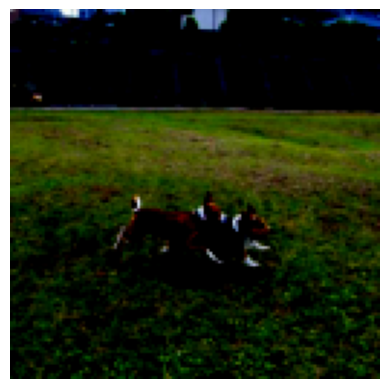

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

try:
    sample_img = Image.open(sample_img_path).convert('RGB')
except Exception as e:
    print(f"Error: {e}")
else:
    sample_img_tensor = manual_transform(sample_img)
    print(f"Image tensor shape: {sample_img_tensor.shape}")
    
    # Display the image using matplotlib
    plt.imshow(sample_img_tensor.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [10]:
data_loader = create_dataloader(image_paths, manual_transform, batch_size, NUM_WORKERS)

# Iterate over a few batches of data
for batch_idx, images in enumerate(data_loader):
    print(f"Batch {batch_idx+1} - Images shape: {images.shape}")

Batch 1 - Images shape: torch.Size([32, 128, 128, 3])
Batch 2 - Images shape: torch.Size([32, 128, 128, 3])
Batch 3 - Images shape: torch.Size([32, 128, 128, 3])
Batch 4 - Images shape: torch.Size([32, 128, 128, 3])
Batch 5 - Images shape: torch.Size([32, 128, 128, 3])
Batch 6 - Images shape: torch.Size([32, 128, 128, 3])
Batch 7 - Images shape: torch.Size([32, 128, 128, 3])
Batch 8 - Images shape: torch.Size([32, 128, 128, 3])
Batch 9 - Images shape: torch.Size([32, 128, 128, 3])
Batch 10 - Images shape: torch.Size([32, 128, 128, 3])
Batch 11 - Images shape: torch.Size([32, 128, 128, 3])
Batch 12 - Images shape: torch.Size([32, 128, 128, 3])
Batch 13 - Images shape: torch.Size([32, 128, 128, 3])
Batch 14 - Images shape: torch.Size([32, 128, 128, 3])
Batch 15 - Images shape: torch.Size([32, 128, 128, 3])
Batch 16 - Images shape: torch.Size([32, 128, 128, 3])
Batch 17 - Images shape: torch.Size([32, 128, 128, 3])
Batch 18 - Images shape: torch.Size([32, 128, 128, 3])
Batch 19 - Images s

### **UPSAMPLING**

In [11]:
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512), f"Expected (None, 8, 8, 512) but got {model.output_shape}"

    # First Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256), f"Expected (None, 8, 8, 256) but got {model.output_shape}"
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128), f"Expected (None, 16, 16, 128) but got {model.output_shape}"
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64), f"Expected (None, 32, 32, 64) but got {model.output_shape}"
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32), f"Expected (None, 64, 64, 32) but got {model.output_shape}"
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Output Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3), f"Expected (None, 128, 128, 3) but got {model.output_shape}"

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     3,276,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 3)    │         2,400 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,764,192 (29.62 MB)

 Trainable params: 7,697,696 (29.36 MB)

 Non-trainable params: 66,496 (259.75 KB)

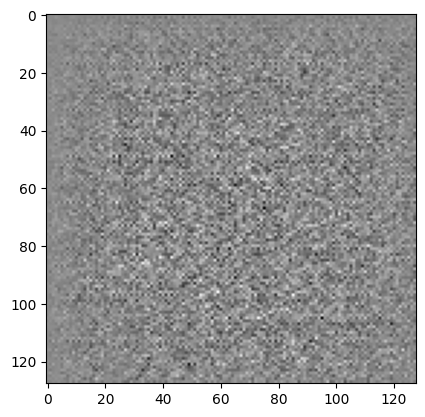

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100]) #latent space
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### **DOWNSAMPLING**

In [13]:
from tensorflow.keras import layers

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,339,329 (16.55 MB)

 Trainable params: 4,339,329 (16.55 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-9.498552e-05]], shape=(1, 1), dtype=float32)


## Let us Define LOSS for Generator and Discrminator

In [15]:
# Defining the loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## **Discriminator loss** -- iscriminator is able to distinguish real images from fakes.

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## **Generator loss**  -- trick the discriminator.


In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
# we are using Adam optimizer here for faster convergence

gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

**Save checkpoints**
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=generator,
                                 discriminator=discriminator)

## **Training**

In [20]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Generating Noise:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [21]:
@tf.function  # compiling and optimizing
def train_steps(images):
    noise = tf.random.normal([batch_size,noise_dim])
    
    # Here we use Gradient_tape for both Generator and Discriminator for Gradient production
    with tf.GradientTape() as Generator_tape , tf.GradientTape() as Discrminator_tape:
        generated_images = generator(noise,training=True)
        
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        # loss
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
    grad_of_gen = Generator_tape.gradient(gen_loss,generator.trainable_variables)
    grad_of_disc = Discrminator_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    # optimizers
    
    gen_opt.apply_gradients(zip(grad_of_gen,generator.trainable_variables))
    disc_opt.apply_gradients(zip(grad_of_disc,discriminator.trainable_variables))
    
    real_accuracy = tf.reduce_mean(tf.cast(tf.greater(real_output, 0.5), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.less(fake_output, 0.5), tf.float32))
    disc_accuracy = (real_accuracy + fake_accuracy) / 2.0
    
    return gen_loss, disc_loss, disc_accuracy

### **Above code is to generate fake and real images**

In [22]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### **Below code is for training Gen and Disc**

In [23]:
from IPython import display
import time

def train(dataset, epochs):
    gen_losses = []
    disc_losses = []
    disc_accuracies = []

    for epoch in range(epochs):
        start = time.time()
        
        total_gen_loss = 0
        total_disc_loss = 0
        total_disc_accuracy = 0
        num_batches = 0
        
        for image_batch in dataset:
            gen_loss, disc_loss, disc_accuracy = train_steps(image_batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            total_disc_accuracy += disc_accuracy
            num_batches += 1
        
        avg_gen_loss = total_gen_loss / num_batches
        avg_disc_loss = total_disc_loss / num_batches
        avg_disc_accuracy = total_disc_accuracy / num_batches
        
        # Append losses and accuracy to the lists
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)
        disc_accuracies.append(avg_disc_accuracy)
        
        # Clear the output and generate images
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        # Print the time, losses, and accuracy for the epoch
        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')
        print(f'Generator loss: {avg_gen_loss:.4f}, Discriminator loss: {avg_disc_loss:.4f}, Discriminator accuracy: {avg_disc_accuracy:.4f}')
    
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    
    # Print final metrics
    print(f'Final Generator loss: {gen_losses[-1]:.4f}')
    print(f'Final Discriminator loss: {disc_losses[-1]:.4f}')
    print(f'Final Discriminator accuracy: {disc_accuracies[-1]:.4f}')




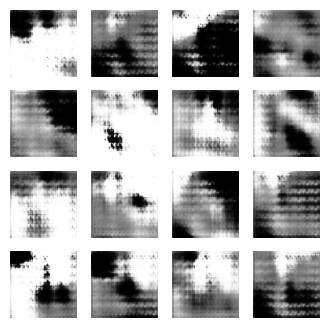

Final Generator loss: 7.1999
Final Discriminator loss: 0.2078
Final Discriminator accuracy: 0.9651


In [24]:
train(data_loader, EPOCHS)

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

 24/112 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

I0000 00:00:1716805120.630211    2211 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
Fake image 0: Predicted probability = -7.6304


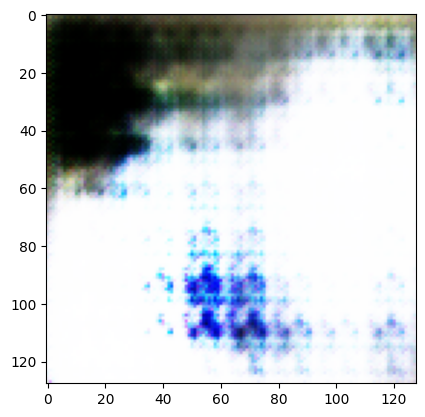

Fake image 1: Predicted probability = -6.9552


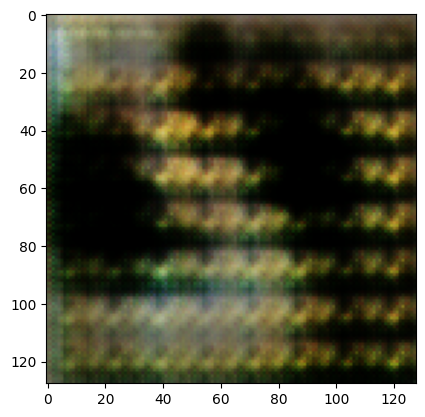

Fake image 2: Predicted probability = -6.2406


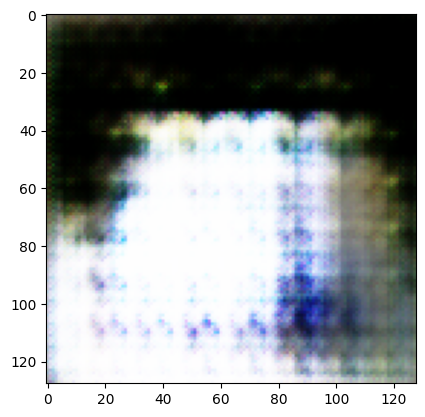

Real image 3: Predicted probability = 7.9606


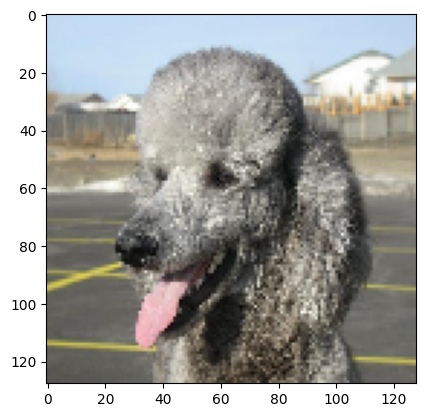

Fake image 4: Predicted probability = -7.3646


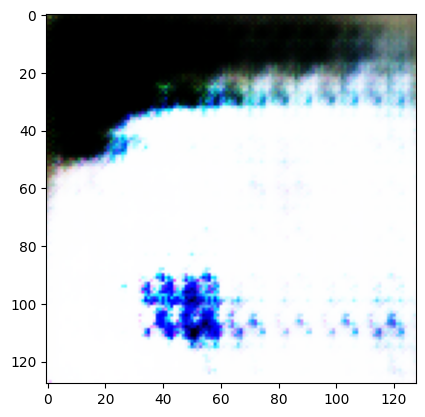

Fake image 5: Predicted probability = -8.8012


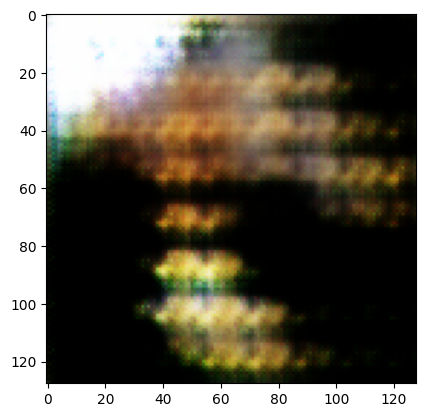

Fake image 6: Predicted probability = -9.7502


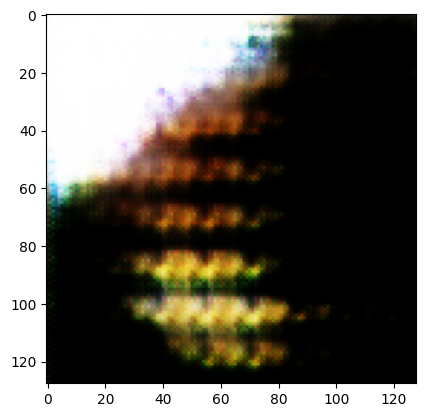

Fake image 7: Predicted probability = -3.4779


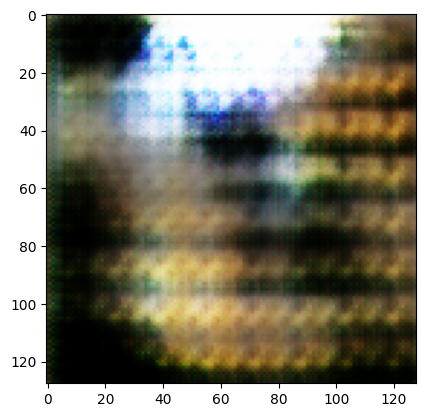

Fake image 8: Predicted probability = 3.7290


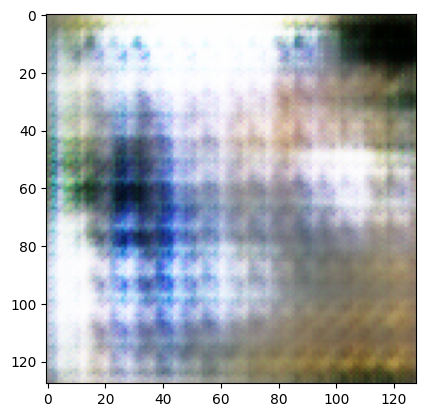

Fake image 9: Predicted probability = -7.5836


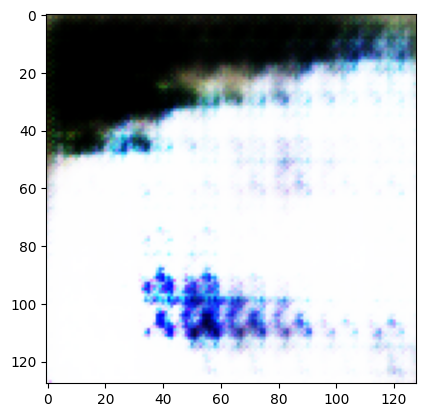

Real image 10: Predicted probability = 9.4439


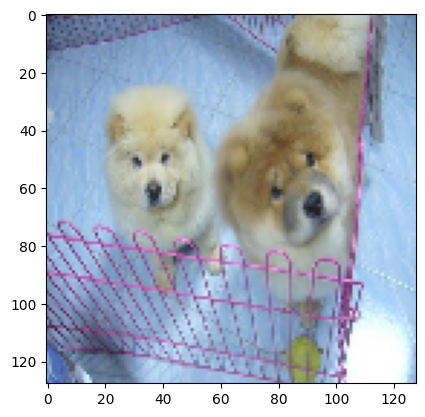

Fake image 11: Predicted probability = -8.3960


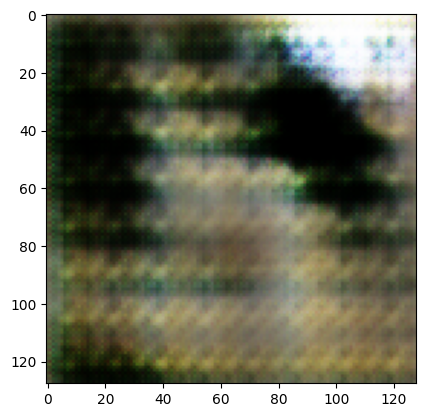

Real image 12: Predicted probability = 8.6432


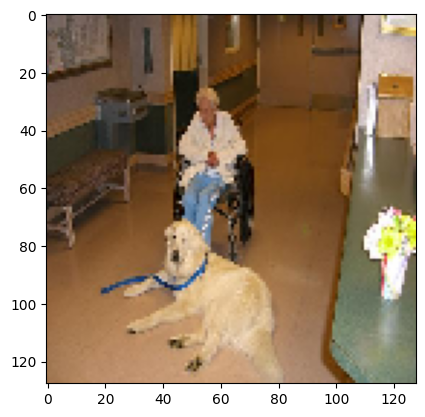

Real image 13: Predicted probability = 7.3748


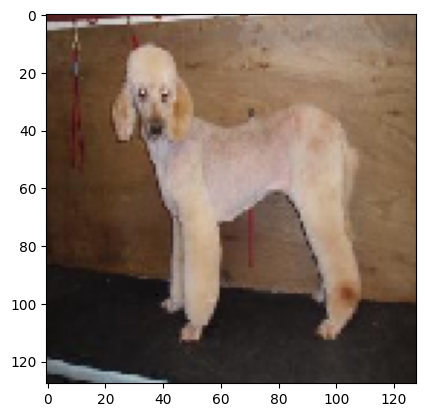

Fake image 14: Predicted probability = -7.7332


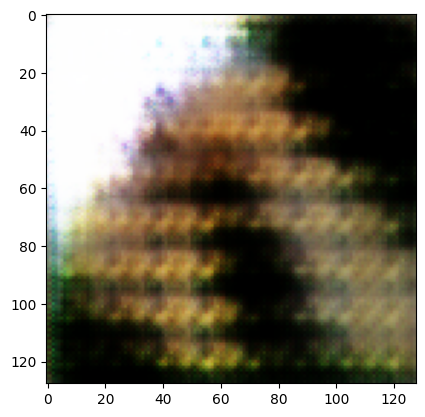

Fake image 15: Predicted probability = -11.0876


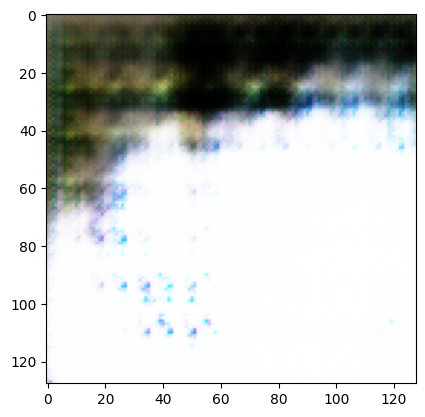

Real image 16: Predicted probability = 5.0845


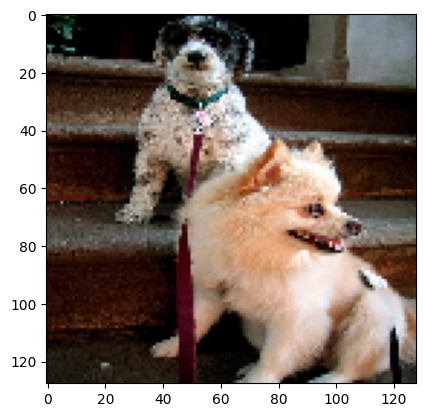

Real image 17: Predicted probability = 2.2945


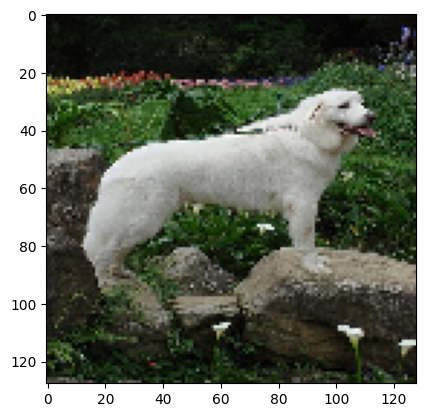

Real image 18: Predicted probability = 8.6644


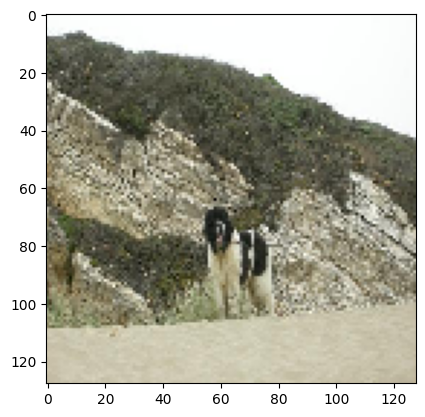

Fake image 19: Predicted probability = -3.7817


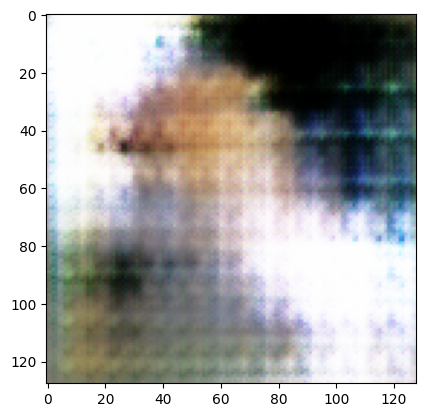

In [28]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_width, img_height = 128, 128

real_images = []
labels = []
for img_path in image_paths:
    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = (img_array - 127.5) / 127.5
    real_images.append(img_array)
    labels.append(1)

real_images = np.array(real_images)
labels = np.array(labels)

noise = np.random.normal(0, 1, (len(real_images), 100))
fake_images = generator.predict(noise)

images = np.concatenate((real_images, fake_images))
labels = np.concatenate((labels, np.zeros(len(fake_images))))

indices = np.random.permutation(len(images))
images = images[indices]
labels = labels[indices]

predictions = discriminator.predict(images)

for i in range(20):
    if labels[i] == 1:
        print(f"Real image {i}: Predicted probability = {predictions[i][0]:.4f}")
    else:
        print(f"Fake image {i}: Predicted probability = {predictions[i][0]:.4f}")

    img = (images[i] * 127.5 + 127.5).astype(np.uint8)
    plt.imshow(img)
    plt.show()